# LSTM Model

This notebook is used to develop an LSTM model for predicting Dow Jones stocks on all csv files in repository.  

We will plot the predicted accuracy of close values from all stocks based on the LSTM model (5-day future point).

### Packages

First, we load important packages.

In [1]:
#import some useful packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM

D:\Users\Sanket_Mishra\Anaconda3\envs\PythonData\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Define Functions 

Now, we define and instantiate our pre-made functions.

In [2]:
#function to create training and test data from a dataframe
def train_test_splitter(df, seq_length, fut_point, train_split):
    #save data as a matrix
    data = df.values
    
    #save number of features
    features = data.shape[1]
    
    #get X data (30 day sequences)
    X = []
    #get all sequences up to (sequence length + future point) days out of last point (can then predict last point)
    for index in range(len(data) - seq_length - fut_point):
        X.append(data[index: index + seq_length])
    #get X as a numpy array
    X = np.array(X)
    
    #get Y data (close price for all days except first (sequence length + future point) days)
    y = data[(seq_length + fut_point):, -1]
    
    #create train/test splits using chosing training split (between 0 and 1)
    last_row = int(train_split * X.shape[0])
    X_train = X[:last_row]
    X_test = X[last_row:]
    y_train = y[:last_row]
    y_test = y[last_row:]
    return X_train, X_test, y_train, y_test

In [3]:
#function to create scaled data and scalers
def create_scalers_and_normalize(X_train, X_test, y_train, y_test):
    #instantiate scalers
    X_scaler = MinMaxScaler(feature_range = (-1, 1))
    y_scaler = MinMaxScaler(feature_range = (-1, 1))
    
    #get number of features
    features = X_train.shape[2]
    
    #reshape data so it can be fit
    X_train_reshaped = np.reshape(X_train, (-1, features))
    X_test_reshaped = np.reshape(X_test, (-1, features))
    y_train_reshaped = np.reshape(y_train, (-1, 1))
    y_test_reshaped = np.reshape(y_test, (-1, 1))
    
    #fit scalers
    X_scaler.fit(X_train_reshaped)
    y_scaler.fit(y_train_reshaped)
    
    #transform and rescale
    X_train_scaled = np.reshape(X_scaler.transform(X_train_reshaped), X_train.shape)
    X_test_scaled = np.reshape(X_scaler.transform(X_test_reshaped), X_test.shape)
    y_train_scaled = np.reshape(y_scaler.transform(y_train_reshaped), y_train.shape[0])
    y_test_scaled = np.reshape(y_scaler.transform(y_test_reshaped), y_test.shape[0])
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler

In [4]:
#create an LSTM model with different neuron sizes
def create_generic_LSTM_model(neurons, dropout, seq_length, features):
    #create an LSTM model
    model = Sequential()

    #add first LSTM layer and dropout layer
    model.add(LSTM(neurons[0], return_sequences = True, input_shape = (seq_length, features)))
    model.add(Dropout(0.2))

    #add second LSTM layer and dropout layer
    model.add(LSTM(neurons[1], return_sequences = False))
    model.add(Dropout(0.2))

    #add an reLU layer
    model.add(Dense(neurons[2], activation = 'relu'))

    #add a final layer
    model.add(Dense(1, activation = 'linear'))

    #compile model
    model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

    return model

In [5]:
#function to evaluate score and return predictions for a given model path
import math
def make_preds(model_path, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, y_scaler):
    #load model
    model = load_model(model_path)
    
    #score models
    train_score = model.evaluate(X_train_scaled, y_train_scaled, verbose = 0)
    test_score = model.evaluate(X_test_scaled, y_test_scaled, verbose = 0)
    train_rmse = math.sqrt(train_score[0])
    test_rmse = math.sqrt(test_score[0])
    #Commented out print statements so for loop doesn't excessively output data 
    
    #print(f"Training Set- Score: {train_score[0]}, RMSE: {train_rmse}")
    #print(f"Test Set- Score: {test_score[0]}, RMSE: {test_rmse}")
    
    #evaluate model on training set and test set
    y_train_preds_scaled = model.predict(X_train_scaled)
    y_test_preds_scaled = model.predict(X_test_scaled)
    
    #rescale results
    y_train_preds_denormed = y_scaler.inverse_transform(y_train_preds_scaled)
    y_test_preds_denormed = y_scaler.inverse_transform(y_test_preds_scaled)
    
    #reshape results for plotting
    y_train_preds = np.reshape(y_train_preds_denormed, len(y_train_scaled))
    y_test_preds = np.reshape(y_test_preds_denormed, len(y_test_scaled))
    
    return y_train_preds, y_test_preds, train_score, test_score

In [6]:
#function to create, compile, fit a model, and make predictions
def fit_generic_LSTM_model(df, seq_length, fut_point, train_split, neurons, dropout, epochs, batch_size, 
                           validation_split, model_path):
    
    #get train/test split
    X_train, X_test, y_train, y_test = train_test_splitter(df, seq_length, fut_point, train_split)
    
    #get number of features
    features = X_train.shape[2]
    
    #get scalers and normalized data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler = create_scalers_and_normalize(
        X_train, X_test, y_train, y_test)
    
    #create model
    model = create_generic_LSTM_model(neurons, dropout, seq_length, features)
    
    #fit model
    #Reduced verbose to 0 so you don't see the model fit for every epoch in every csv file
    model.fit(X_train_scaled, y_train_scaled, epochs = epochs, 
              batch_size = batch_size, validation_split = validation_split, verbose = 0)
    
    #save model
    model.save(model_path)
    
    #evaluate model and get predictions
    y_train_preds, y_test_preds, train_score, test_score = make_preds(model_path, 
                                                                      X_train_scaled, X_test_scaled, 
                                                                      y_train_scaled, y_test_scaled, y_scaler)
    
    #return necessary variables to create predictions
    return y_train, y_test, y_train_preds, y_test_preds, train_score, test_score

In [7]:
def see_history(df, seq_length, fut_point, train_split, neurons, dropout, epochs, batch_size, 
                           validation_split, model_path):
    
    #get train/test split
    X_train, X_test, y_train, y_test = train_test_splitter(df, seq_length, fut_point, train_split)
    
    #get number of features
    features = X_train.shape[2]
    
    #get scalers and normalized data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler = create_scalers_and_normalize(
        X_train, X_test, y_train, y_test)
    
    #create model
    model = create_generic_LSTM_model(neurons, dropout, seq_length, features)
    
    #fit model
    history = model.fit(X_train_scaled, y_train_scaled, epochs = epochs, 
              batch_size = batch_size, validation_split = validation_split, verbose = 1)
    
    #save model
    model.save(model_path)
    
    return history

# Generic Stock

There are actually 30 Dow Jones Stocks.  We need a function to produce a model for a generic filepath.

In [8]:
#function to produce predictions for a generic filepath
def generic_stock_predictions(filepath, stock_name, seq_length, fut_point):
    
    #define variables
    train_split = 0.85
    neurons = [128, 128, 16]
    #Reduced epochs to 10 so I could test stockOutput values and generate plots without waiting for long run time
    epochs = 10
    batch_size = 32
    validation_split = 0.1
    dropout = 0.3
    
    #define model path
    model_path = stock_name + '_model.h5'
    
    #read in data frame and drop unnescessary columns
    df = pd.read_csv(filepath)
    df.drop(['volume', 'unadjustedVolume', 'change', 'changePercent', 'vwap', 'label', 
             'changeOverTime'], 1, inplace = True)
    df.set_index('date', inplace = True)
    
    #fit model
    y_train, y_test, y_train_preds, y_test_preds, train_score, test_score = fit_generic_LSTM_model(df, 
                                                                                                     seq_length, 
                                                                                                     fut_point, 
                                                                                                     train_split, 
                                                                                                     neurons, 
                                                                                                     dropout, 
                                                                                                     epochs, 
                                                                                                     batch_size,
                                                                                                     validation_split, 
                                                                                                     model_path)
    
    #return
    return y_train, y_test, y_train_preds, y_test_preds, train_score, test_score

In [9]:
#predicted profitability function
def predicted_profit(filepath, stock_name, seq_length, fut_point):
    
    #fit model
    y_train, y_test, y_train_preds, y_test_preds, train_score, test_score = generic_stock_predictions(
        filepath, stock_name, seq_length, fut_point)
    
    #get values
    start_close = y_test[-1-fut_point]
    end_close = y_test[-1]
    pred_close = y_test_preds[-1]
    actual_profit = (end_close - start_close)*100/start_close
    pred_profit = (pred_close - start_close)*100/start_close
    
    #create dictionary for output
    stock_dictionary = {'Stock': stock_name, 'Start Close': start_close, 'End Close': end_close, 
                       'Predicted Close': pred_close, 'Actual Profit': actual_profit, 'Predicted Profit': pred_profit}
    
    return stock_dictionary
    

# Iterate through all CSV's

Now that the functions are instantiated we can start iterating through our files and storing their output.

In [10]:
#Generate Stock Names for filepath and output dictionary
stockFiles = ["AAPL", "AXP", "BA", "CAT", "CSCO", "CVX", "DIS", "DWDP", "GS", "HD", "IBM", "INTC", "JNJ", "JPM", "KO", 
              "MCD", "MMM", "MRK", "MSFT", "NKE", "PFE", "PG", "TRV", "UNH", "UTX", "V", "VZ", "WBA", "WMT", "XOM"]

In [11]:
#Create empty array to store output dictionary
stockOutput = []

In [12]:
for stock in stockFiles:
    file = stock + ".csv"
    filepath = os.path.join('..', 'Resources', file)
    dictionary = predicted_profit(filepath, stock, 30, 5)
    print(dictionary)
    stockOutput.append(dictionary)

{'Stock': 'AAPL', 'Start Close': 155.86, 'End Close': 157.76, 'Predicted Close': 151.15967, 'Actual Profit': 1.219042730655702, 'Predicted Profit': -3.0157397865071305}
{'Stock': 'NKE', 'Start Close': 79.13, 'End Close': 80.61, 'Predicted Close': 71.421455, 'Actual Profit': 1.8703399469227904, 'Predicted Profit': -9.741620898141305}


In [13]:
stockOutput

[{'Stock': 'AAPL',
  'Start Close': 155.86,
  'End Close': 157.76,
  'Predicted Close': 151.15967,
  'Actual Profit': 1.219042730655702,
  'Predicted Profit': -3.0157397865071305},
 {'Stock': 'AXP',
  'Start Close': 99.49,
  'End Close': 100.77,
  'Predicted Close': 95.91425,
  'Actual Profit': 1.286561463463666,
  'Predicted Profit': -3.5940765555701213},
 {'Stock': 'BA',
  'Start Close': 359.09,
  'End Close': 364.2,
  'Predicted Close': 313.60486,
  'Actual Profit': 1.4230415773204528,
  'Predicted Profit': -12.66678036190439},
 {'Stock': 'CAT',
  'Start Close': 133.68,
  'End Close': 136.86,
  'Predicted Close': 130.8988,
  'Actual Profit': 2.378815080789951,
  'Predicted Profit': -2.0804879481317373},
 {'Stock': 'CSCO',
  'Start Close': 44.21,
  'End Close': 46.13,
  'Predicted Close': 40.761047,
  'Actual Profit': 4.342908844152911,
  'Predicted Profit': -7.801295265140808},
 {'Stock': 'CVX',
  'Start Close': 111.96,
  'End Close': 113.22,
  'Predicted Close': 112.82812,
  'Actua

In [14]:
len(stockOutput)

30

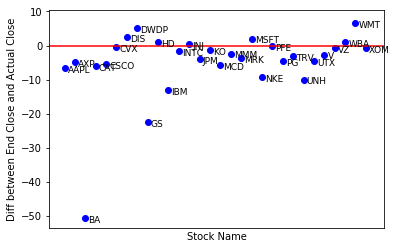

In [24]:
#Plot points on scatter plot
import matplotlib.pyplot as plt
for index in range(0,len(stockOutput)):
    closeDifference = stockOutput[index]['Predicted Close'] - stockOutput[index]['End Close']
    plt.scatter(index, closeDifference, c='blue')
    plt.text(index+0.3, closeDifference-1.3, stockOutput[index]['Stock'], fontsize=9)
    
#Outside of for loop
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Stock Name")
plt.ylabel("Diff between End Close and Actual Close")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

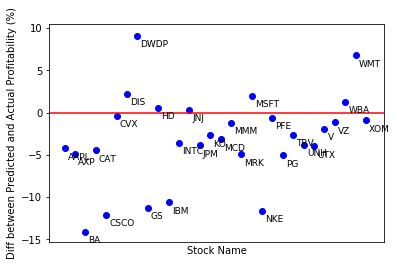

In [29]:
import matplotlib.pyplot as plt
#Plot points on scatter plot
for index in range(0,len(stockOutput)):
    profitabilityDifference = stockOutput[index]['Predicted Profit'] - stockOutput[index]['Actual Profit']
    plt.scatter(index, profitabilityDifference, c='blue')
    plt.text(index+0.3, profitabilityDifference-1.3, stockOutput[index]['Stock'], fontsize=9)
    
#Outside of for loop
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Stock Name")
plt.ylabel("Diff between Predicted and Actual Profitability (%)")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()